In [1]:
# Зависимости
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import mean_squared_error, f1_score, silhouette_score

from sklearn import preprocessing

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout

2022-04-17 15:33:39.196546: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-17 15:33:39.196619: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Инициализируем все известные генераторы случаынйх чисел / Setting all known random seeds
my_code = "МагдиевО"
seed_limit = 2 ** 32
my_seed = int.from_bytes(my_code.encode(), "little") % seed_limit

os.environ['PYTHONHASHSEED']=str(my_seed)

random.seed(my_seed)

np.random.seed(my_seed)

tf.compat.v1.set_random_seed(my_seed)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2022-04-17 15:33:43.001354: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-17 15:33:43.001899: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-17 15:33:43.001931: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-17 15:33:43.001959: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-mosalov-2dnotebook-5ffor-5fai-5fmain-2dza7nkegk): /proc/driver/nvidia/version does not exist


In [3]:
# Читаем данные из файла
train_data = pd.read_csv("datasets/iris_train.csv")

In [4]:
train_data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.7,2.6,3.5,1.0,Iris-versicolor
1,5.1,3.8,1.5,0.3,Iris-setosa
2,5.4,3.9,1.3,0.4,Iris-setosa
3,6.5,3.0,5.2,2.0,Iris-virginica
4,6.9,3.1,4.9,1.5,Iris-versicolor


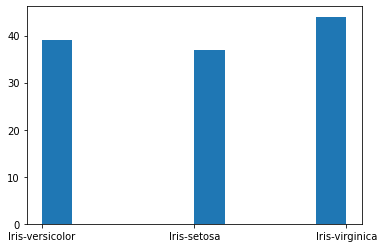

In [5]:
classes = train_data['species']
plt.hist(classes)
plt.show()

In [6]:
# Определим размер валидационной выборки
val_size = round(0.2*len(train_data))
print(val_size)

24


In [7]:
# Создадим обучающую и валидационную выборки
random_state = my_seed
train, val = train_test_split(train_data, test_size=val_size, random_state=random_state)
print(len(train), len(val))

96 24


In [8]:
# Значения в числовых столбцах преобразуем к отрезку [0,1].
# Для настройки скалировщика используем только обучающую выборку.
num_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
ord_columns = ['species']

ct = ColumnTransformer(transformers=[('numerical', MinMaxScaler(), num_columns)], remainder='passthrough')

ct.fit(train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', MinMaxScaler(),
                                 ['sepal_length', 'sepal_width', 'petal_length',
                                  'petal_width'])])

In [9]:
# Преобразуем значения, тип данных приводим к DataFrame
sc_train = pd.DataFrame(ct.transform(train))
sc_val = pd.DataFrame(ct.transform(val))

In [10]:
# Устанавливаем названия столбцов
column_names = num_columns + ord_columns
sc_train.columns = column_names
sc_val.columns = column_names

In [11]:
sc_train

,sepal_length,sepal_width,petal_length,petal_width,species
0,0.222222,0.625,0.067797,0.041667,Iris-setosa
1,0.527778,0.583333,0.745763,0.916667,Iris-virginica
2,0.194444,0.125,0.389831,0.375,Iris-versicolor
3,0.388889,0.208333,0.677966,0.791667,Iris-virginica
4,0.138889,0.583333,0.152542,0.041667,Iris-setosa
...,...,...,...,...,...
91,0.527778,0.333333,0.644068,0.708333,Iris-virginica
92,0.194444,0.416667,0.101695,0.041667,Iris-setosa
93,0.555556,0.541667,0.847458,1.0,Iris-virginica
94,0.333333,0.208333,0.508475,0.5,Iris-versicolor


In [12]:
# Отберем необходимые параметры
x_train = sc_train[num_columns]
x_val = sc_val[num_columns]

y_train = (sc_train[ord_columns].values).flatten()
y_val = (sc_val[ord_columns].values).flatten()

In [13]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()

]

In [14]:
for model in classifiers:
    print(model)
    model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)
SVC(C=0.025, kernel='linear')
SVC(C=1, gamma=2)
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
DecisionTreeClassifier(max_depth=5)
RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10)
MLPClassifier(alpha=1, max_iter=1000)
AdaBoostClassifier()
GaussianNB()
QuadraticDiscriminantAnalysis()


In [15]:
# Оценииваем качество работы моделей на валидационной выборке.
f1s = []
for model in classifiers:
    val_pred = model.predict(x_val)
    f1 = f1_score(y_val, val_pred, average='weighted')
    f1s.append(f1)
    print(model, '\t', f1)

KNeighborsClassifier(n_neighbors=3) 	 1.0
SVC(C=0.025, kernel='linear') 	 0.48133116883116883
SVC(C=1, gamma=2) 	 0.9580136402387042
GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1)) 	 0.9580136402387042
DecisionTreeClassifier(max_depth=5) 	 0.9580136402387042
RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10) 	 0.9580136402387042
MLPClassifier(alpha=1, max_iter=1000) 	 0.9580136402387042
AdaBoostClassifier() 	 0.9580136402387042
GaussianNB() 	 0.9580136402387042
QuadraticDiscriminantAnalysis() 	 0.9580136402387042


In [16]:
i_max = f1s.index(max(f1s))
best_c_model = classifiers[i_max]
best_c_model

KNeighborsClassifier(n_neighbors=3)

In [17]:
test = pd.read_csv("datasets/iris_test.csv")

In [18]:
test['species'] = ''

In [19]:
test.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.4,3.7,1.5,0.2,
1,6.0,3.4,4.5,1.6,
2,5.9,3.0,4.2,1.5,
3,5.7,3.0,4.2,1.2,
4,5.6,2.7,4.2,1.3,


In [20]:
sc_test = pd.DataFrame(ct.transform(test))
sc_test.columns = column_names

In [21]:
x_test = sc_test[num_columns]

In [22]:
test['species'] = best_c_model.predict(x_test)

In [23]:
test.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.4,3.7,1.5,0.2,Iris-setosa
1,6.0,3.4,4.5,1.6,Iris-versicolor
2,5.9,3.0,4.2,1.5,Iris-versicolor
3,5.7,3.0,4.2,1.2,Iris-versicolor
4,5.6,2.7,4.2,1.3,Iris-versicolor


In [24]:
test_pred = best_c_model.predict(x_test)
f1 = f1_score(y_val, val_pred, average='weighted')
print(f1)

0.9580136402387042


In [25]:
test.to_csv('task4_results/Магдиев О.А..csv', index=False)